In [1]:
%matplotlib inline
import numpy as np
import pymc3 as pm
import pandas as pd
import matplotlib.pyplot as plt
from loader import load_data
import arviz as az
import seaborn as sns
sns.set(rc={'figure.figsize':(12,8)})
sns.set_theme()

from IPython.display import display, Markdown
az.style.use('arviz-darkgrid')
np.random.seed(44)

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


In [2]:
plt.rcParams['font.size'] = 11
plt.rcParams['legend.fontsize'] = 'small'
plt.rcParams.update({
    "figure.figsize": [8, 4],
    'figure.constrained_layout.use': True,
    'font.size': 11.0,
    'hist.bins': 'auto',
    'lines.linewidth': 3.0,
    'lines.markeredgewidth': 2.0,
    'lines.markerfacecolor': 'none',
    'lines.markersize': 8.0, 
})

In [3]:
df = load_data(r"data_hockey")
df = df.loc[df.Resultat != " -:-"].reset_index(drop=True)
df

,Tag,Datum,Zeit,Home,Away,Resultat,Drittel,OT/SO,Status,Versch.,Stadion,Zus.,Id,Liga,Region,Phase,TV/Online
0,Mi,09.09.2015,19:45,ZSC Lions,SC Bern,5:3,1:0|2:3|2:0,NaN,Ende,False,"Hallenstadion AG, Zürich",9038,20161105071114,NL A,CH,Regular Season,NaN
1,Fr,11.09.2015,19:45,SC Bern,SCL Tigers,7:1,1:0|4:1|2:0,NaN,Ende,False,"PostFinance-Arena, Bern",17031,20161105071001,NL A,CH,Regular Season,NaN
2,Fr,11.09.2015,19:45,HC Davos,Fribourg-Gottéron,4:5,1:0|1:3|2:1|0:1,SO,Ende,False,"Vaillant Arena, Davos",4488,20161105071002,NL A,CH,Regular Season,NaN
3,Fr,11.09.2015,19:45,Genève-Servette HC,HC Ambri-Piotta,8:2,1:2|4:0|3:0,NaN,Ende,False,"Les Vernets, Genève",5804,20161105071003,NL A,CH,Regular Season,NaN
4,Fr,11.09.2015,19:45,EHC Kloten,EHC Biel-Bienne,3:7,2:1|0:3|1:3,NaN,Ende,False,"SWISS Arena, Kloten",4152,20161105071004,NL A,CH,Regular Season,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2445,Sa,23.04.2022,20:00,EV Zug,ZSC Lions,1:2,1:0|0:0|0:2,NaN,Ende,False,"BOSSARD Arena, 6303 Zug",7200,20221105000413,NL,CH,Playoff Final,"SRF,RTS,RSI,MYSPORTS"
2446,Mo,25.04.2022,20:00,ZSC Lions,EV Zug,1:4,1:1|0:1|0:2,NaN,Ende,False,"Hallenstadion, 8050 Zürich ZH",11200,20221105000414,NL,CH,Playoff Final,"SRF,RTS,RSI,MYSPORTS"
2447,Mi,27.04.2022,20:00,EV Zug,ZSC Lions,4:1,0:0|1:1|3:0,NaN,Ende,False,"BOSSARD Arena, 6303 Zug",7200,20221105000415,NL,CH,Playoff Final,"SRF,RTS,RSI,MYSPORTS"
2448,Fr,29.04.2022,20:00,ZSC Lions,EV Zug,0:2,0:1|0:0|0:1,NaN,Ende,False,"Hallenstadion, 8050 Zürich ZH",11200,20221105000416,NL,CH,Playoff Final,"SRF,RTS,RSI,MYSPORTS"


# Preprocessing and data exploration

In [4]:
# Get unique team names
teams = pd.concat([df["Home"], df["Away"]]).unique()

# Create a new DataFrame for one-hot encoding
encoded_df = pd.DataFrame(index=df.index)

# Create a column for each team and set default value to 0
for team in teams:
    encoded_df[team] = 0

# Mark the corresponding team column with 1
for i, row in df.iterrows():
    encoded_df.at[i, row["Home"]] = 1
    encoded_df.at[i, row["Away"]] = 1

# Concatenate the original DataFrame with the encoded columns
result_df = pd.concat([df, encoded_df], axis=1)

result_df['Datum'] = pd.to_datetime(result_df['Datum'], format='%d.%m.%Y')


for team in teams:
    team_subset = result_df[result_df[team] == 1].copy()
    team_subset.loc[:, team] = team_subset['Datum'].diff().dt.days - 1
    result_df.update(team_subset)


result_df['Home_rest_days'] = result_df.apply(lambda x: x[x['Home']], axis=1)
result_df['Away_rest_days'] = result_df.apply(lambda x: x[x['Away']], axis=1)
result_df.reset_index(drop=True, inplace=True)

In [5]:
# Convert the 'Datum' column to datetime
result_df['Datum'] = pd.to_datetime(result_df['Datum'], format='%d.%m.%Y')


# Split the Resultat into home and away goals
result_df['Home_goals'] = result_df['Resultat'].str.split(':').str[0].astype(int)
result_df['Away_goals'] = result_df['Resultat'].str.split(':').str[1].astype(int)

# Create a new dataframe in the Spotify format
home_df = result_df[['Home', 'Away', 'Home_goals', 'Home_rest_days', 'Tag']]
away_df = result_df[['Away', 'Home', 'Away_goals', 'Away_rest_days', 'Tag']]

hockey_df = pd.concat([home_df, away_df]).sort_values(by="Home").reset_index(drop=True).fillna(0)

In [6]:
hockey_df

,Home,Away,Home_goals,Home_rest_days,Tag,Away_goals,Away_rest_days
0,EHC Biel-Bienne,Genève-Servette HC,7.0,3.0,Sa,0.0,0.0
1,EHC Biel-Bienne,Lausanne HC,1.0,2.0,Fr,0.0,0.0
2,EHC Biel-Bienne,HC Davos,0.0,0.0,Di,2.0,2.0
3,EHC Biel-Bienne,ZSC Lions,1.0,5.0,Fr,0.0,0.0
4,EHC Biel-Bienne,EV Zug,4.0,3.0,Sa,0.0,0.0
...,...,...,...,...,...,...,...
4895,ZSC Lions,HC Davos,5.0,1.0,Sa,0.0,0.0
4896,ZSC Lions,HC Ambri-Piotta,0.0,0.0,So,2.0,1.0
4897,ZSC Lions,Fribourg-Gottéron,1.0,4.0,Do,0.0,0.0
4898,ZSC Lions,EHC Kloten,3.0,1.0,Sa,0.0,0.0


In [7]:
# Create new dataframes for home and away games, now also include days_of_rest
home_df = hockey_df[['Home', 'Home_goals', 'Home_rest_days', 'Tag']].rename(columns={'Home':'Team', 'Home_goals':'Goals', 'Home_rest_days':'days_of_rest', 'Tag':'day_of_the_week'})
away_df = hockey_df[['Away', 'Away_goals', 'Away_rest_days', 'Tag']].rename(columns={'Away':'Team', 'Away_goals':'Goals', 'Away_rest_days':'days_of_rest',  'Tag':'day_of_the_week'})

# Concatenate these dataframes
flattened_df = pd.concat([home_df, away_df], axis=0).reset_index(drop=True)

# Assign a numerical code to each team
flattened_df['team_code'] = flattened_df['Team'].astype('category').cat.codes

In [8]:
flattened_df

,Team,Goals,days_of_rest,day_of_the_week,team_code
0,EHC Biel-Bienne,7.0,3.0,Sa,0
1,EHC Biel-Bienne,1.0,2.0,Fr,0
2,EHC Biel-Bienne,0.0,0.0,Di,0
3,EHC Biel-Bienne,1.0,5.0,Fr,0
4,EHC Biel-Bienne,4.0,3.0,Sa,0
...,...,...,...,...,...
9795,HC Davos,0.0,0.0,Sa,7
9796,HC Ambri-Piotta,2.0,1.0,So,6
9797,Fribourg-Gottéron,0.0,0.0,Do,3
9798,EHC Kloten,0.0,0.0,Sa,1


In [9]:
# Split the 'Resultat' column into 'home_goals' and 'away_goals'
df['home_goals'] = df['Resultat'].str.split(':').str[0].astype(int)
df['away_goals'] = df['Resultat'].str.split(':').str[1].astype(int)

# Filter scores for 'SC Bern' when they played at home
hcl_home_scores = df[df['Home'] == 'HC Lugano']['home_goals'].tolist()

# Filter scores for 'SC Bern' when they played away
hcl_away_scores = df[df['Away'] == 'HC Lugano']['away_goals'].tolist()

print(hcl_home_scores)  # [3, 2]
print(hcl_away_scores)  # [4]

[2, 3, 1, 5, 4, 2, 2, 6, 4, 3, 6, 1, 4, 4, 3, 7, 3, 3, 3, 7, 7, 6, 0, 4, 3, 4, 5, 1, 1, 4, 5, 2, 2, 5, 3, 4, 2, 4, 3, 4, 4, 2, 2, 2, 5, 4, 8, 3, 6, 3, 3, 4, 4, 2, 1, 5, 3, 3, 4, 3, 2, 1, 1, 3, 3, 6, 2, 3, 5, 4, 2, 6, 3, 2, 2, 4, 3, 3, 8, 3, 3, 4, 7, 1, 4, 2, 3, 5, 6, 3, 5, 1, 5, 6, 0, 3, 4, 0, 3, 4, 6, 1, 6, 0, 5, 4, 5, 5, 6, 3, 5, 6, 3, 1, 3, 1, 2, 4, 3, 4, 8, 5, 4, 1, 4, 2, 2, 4, 1, 3, 6, 1, 2, 3, 1, 1, 5, 3, 3, 6, 0, 4, 2, 1, 2, 5, 5, 1, 0, 1, 4, 2, 4, 4, 5, 2, 1, 3, 5, 3, 1, 2, 1, 2, 4, 5, 4, 3, 2, 2, 7, 2, 4, 6, 1, 7, 6, 2, 3, 2, 1, 3, 3, 3, 1, 3, 1, 2, 4, 1, 1, 5, 3, 3, 4, 6, 5, 2, 2, 3, 4, 2, 5, 5, 4, 4, 2, 3]
[4, 1, 4, 1, 1, 3, 1, 0, 1, 2, 6, 1, 4, 4, 4, 2, 2, 3, 2, 2, 3, 2, 3, 4, 4, 2, 5, 5, 4, 3, 0, 1, 3, 2, 1, 3, 5, 2, 0, 2, 5, 0, 1, 1, 1, 3, 0, 1, 2, 2, 3, 0, 3, 5, 1, 5, 2, 3, 0, 2, 4, 1, 3, 4, 5, 1, 4, 4, 4, 1, 1, 4, 2, 4, 5, 4, 4, 1, 1, 1, 4, 0, 0, 6, 2, 2, 1, 3, 5, 3, 3, 6, 4, 4, 2, 3, 5, 0, 0, 1, 2, 6, 1, 1, 2, 3, 1, 0, 3, 4, 3, 4, 3, 0, 5, 4, 4, 7, 0, 3, 1, 2, 4, 2, 4,

<AxesSubplot: xlabel='value', ylabel='Count'>

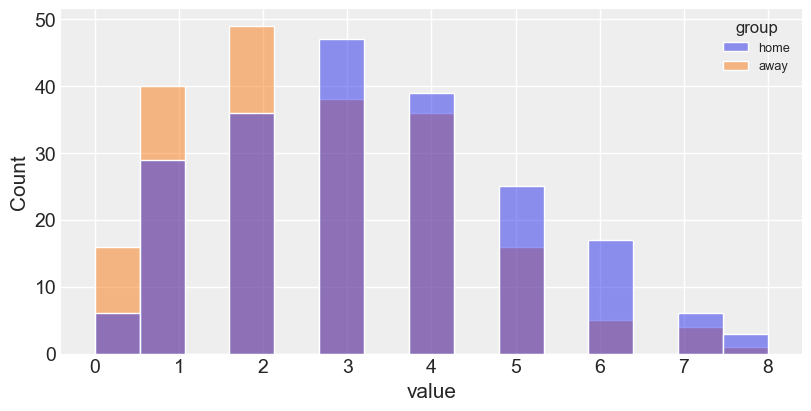

In [10]:
y  = pd.DataFrame(dict(value=np.r_[hcl_home_scores, hcl_away_scores], group=np.r_[['home']*len(hcl_home_scores), ['away']*len(hcl_away_scores)]))
sns.histplot(data=y, x="value", hue="group")

In [11]:
print(f"Sample mean goals at home: {np.mean(hcl_home_scores):.3f}")
print(f"Sample mean goals away: {np.mean(hcl_away_scores):.3f}")

Sample mean goals at home: 3.322
Sample mean goals away: 2.644


# Hypothesis test 1
We want to compare if a team scores more goals while playing at home or away, this concept is called home-field advantage.

# Research question

We want to test if field-home advantage is a real phenomenon:
* Are the goals scored higher when the team plays at home rather than away?

We assume the data is following a Poisson distribution.

# Background information to set the prior
From a research we found the mean goals per game is 5.51 (https://www.sport12x.com/en/mathematics/ice-hockey). Given this we can divide the score between the two teams, resulting in a mean of 2.75 goals per team in one game.

We assume goals scored follow Poisson distribution, then the variance is equal to the mean. This means the standard deviation of goals per team is $SD = \sqrt{mean} = \sqrt{\frac{5.51}{2}} \approx 1.66$

We know that:
$$
\frac{\alpha}{\beta} = \mu
$$
$$
\frac{\alpha}{\beta^2} = \sigma^2
$$

therefore we can calculate alpha and beta as:
$$
\alpha = \frac{\mu^2}{\sigma^2}
$$
$$
\beta = \frac{\mu}{\sigma^2}
$$

In [12]:
mu = 2.75
sigma = 1.37

alpha = mu**2 / sigma**2
beta = mu / sigma**2
alpha, beta

(4.029250359635569, 1.4651819489583886)

# Prior for $\mu_{\text{home}}$ and $\mu_{\text{away}}$

$$
\mu_{\text{home}}   \sim  Gam(4.03,1.47)
$$
$$
\mu_{\text{away}}   \sim  Gam(4.03,1.47)
$$

* We assign the same priors to both groups, so that we are not favoring a group over another a priori.



#  The probabilistic model

* We assume the two population to have different $\sigma$ (often  the same $\sigma$ is assumed for both populations).
$$
\mu_{\text{home}}\sim Gam(4.03,1.47) 
$$
$$
\vec{y}_{\text{home}} \sim Po(\mu_{\text{home}})
$$
$$
\mu_{\text{away}} \sim Gam(4.03,1.47)
$$
$$
\vec{y}_{\text{away}} \sim Po(\mu_{\text{away}})
$$

# Comparing the two means

In [13]:
with pm.Model() as model:
    # prior
    mu_home = pm.Gamma('mu_home', alpha, beta)
    mu_away = pm.Gamma('mu_away', alpha, beta)

    #likelihood of group 1
    y_home = pm.Poisson('y_1', mu=mu_home, observed= hcl_home_scores)

    #likelihood of group 2
    y_away = pm.Poisson('y_2', mu=mu_away, observed= hcl_away_scores)

    #The deterministic variables are function of the parameters, whose values appear in the trace.
    diff_of_means = pm.Deterministic('diff_of_means', mu_home - mu_away)

In [14]:
with model:
    trace = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_away, mu_home]
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.


array([[<AxesSubplot: title={'center': 'mu_home'}>,
        <AxesSubplot: title={'center': 'mu_home'}>],
       [<AxesSubplot: title={'center': 'mu_away'}>,
        <AxesSubplot: title={'center': 'mu_away'}>],
       [<AxesSubplot: title={'center': 'diff_of_means'}>,
        <AxesSubplot: title={'center': 'diff_of_means'}>]], dtype=object)

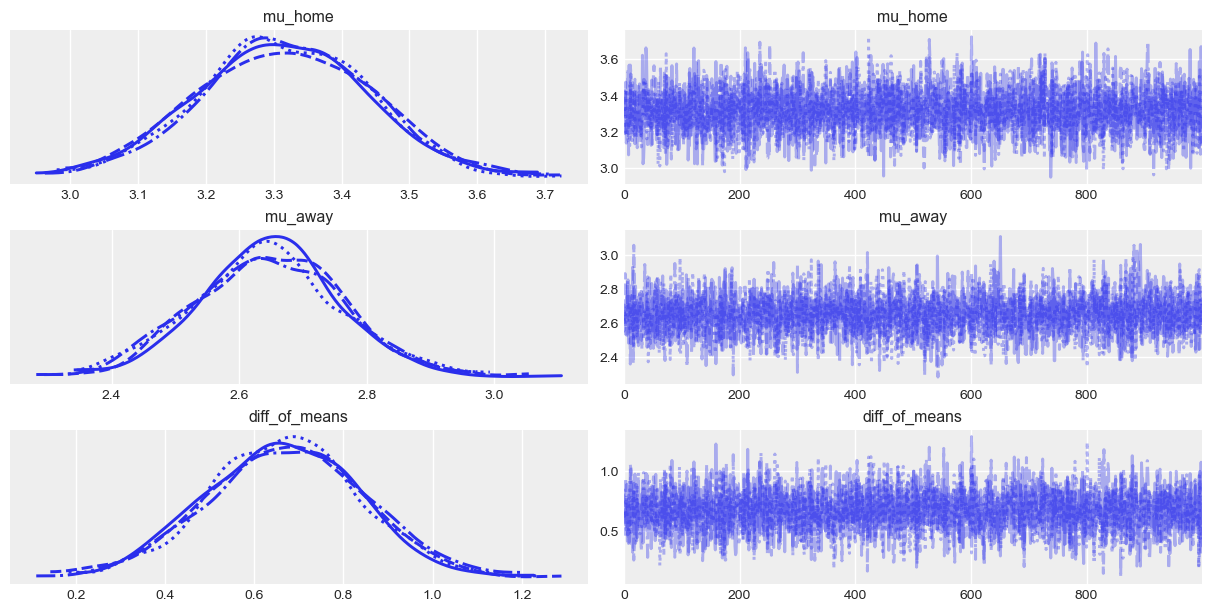

In [15]:
az.plot_trace(trace)

It converges well

In [16]:
az.summary(trace, hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_home,3.315,0.123,3.070,3.549,0.002,0.001,3745.0,2826.0,1.0
mu_away,2.647,0.114,2.426,2.873,0.002,0.001,3370.0,2852.0,1.0
diff_of_means,0.669,0.170,0.322,0.987,0.003,0.002,3706.0,3065.0,1.0


<AxesSubplot: title={'center': 'diff_of_means'}>

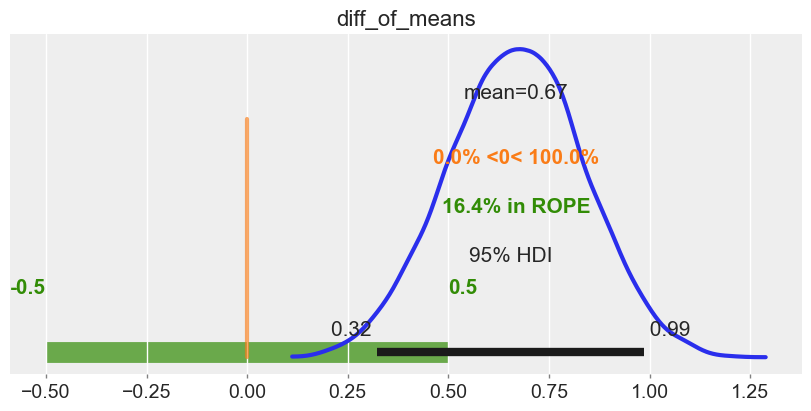

In [17]:
az.plot_posterior(trace,  var_names="diff_of_means", ref_val=0, rope=[-0.5,0.5], hdi_prob=0.95)

In [18]:
samples = az.extract_dataset(trace,)
diff_samples = samples.diff_of_means.values
p_significant_positive =  ((diff_samples > 0.5).sum()) / len(diff_samples)
p_significant_negative = ((diff_samples < -0.5).sum()) / len(diff_samples)
p_practically_eq = 1 -  p_significant_negative  -  p_significant_positive

print("p_significant_positive: ", "%.3f" % p_significant_positive)
print("p_practically_eq: ", "%.3f" % p_practically_eq)
print("p_significant_negative: ", "%.3f" % p_significant_negative)

p_significant_positive:  0.836
p_practically_eq:  0.164
p_significant_negative:  0.000


/var/folders/n3/51xp5_rs54v10cnshxhwyt480000gn/T/ipykernel_50899/2962428823.py:1: FutureWarning: extract_dataset has been deprecated, please use extract
  samples = az.extract_dataset(trace,)


# Posterior predictive checks

/Users/christian/miniforge3/envs/bda/lib/python3.8/site-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


array([<AxesSubplot: xlabel='y_1 / y_1'>,
       <AxesSubplot: xlabel='y_2 / y_2'>], dtype=object)

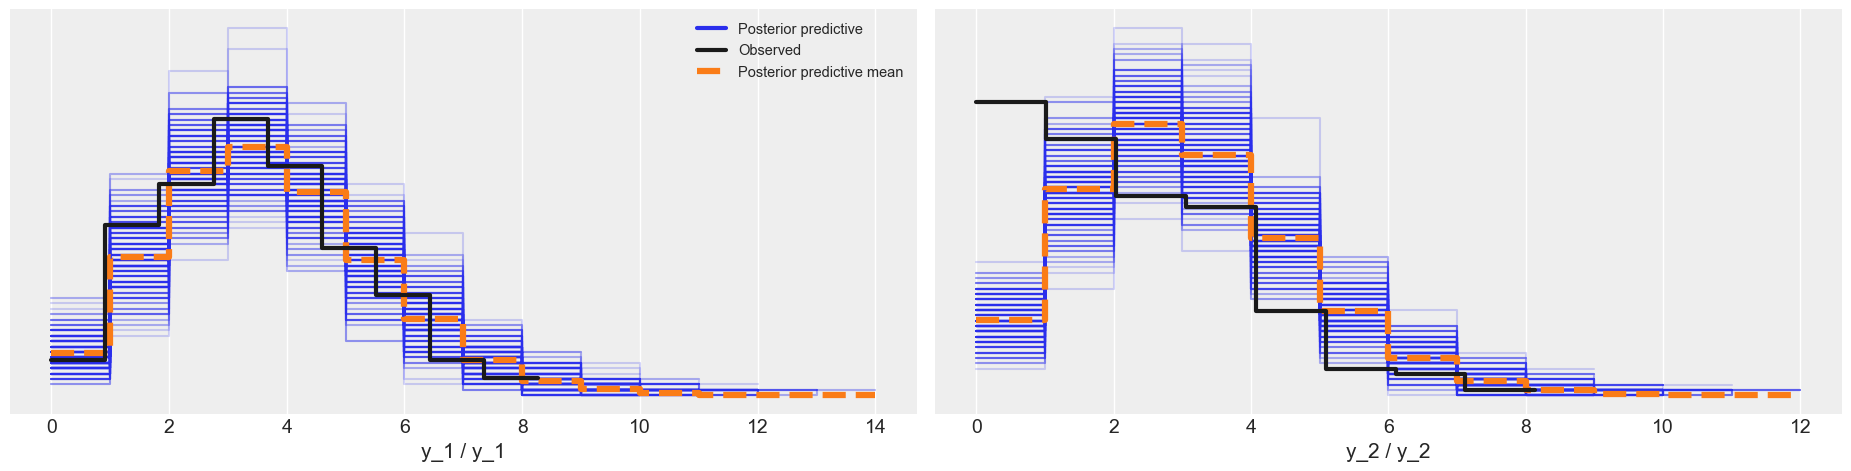

In [19]:
# Quiz yourself: write a pseudo code explaining what the code below does.
with model:
     ppc = pm.sample_posterior_predictive(trace, samples=300)
    
# The density is too low in the bulk of the distribution, for both groups. 
az.plot_ppc(az.from_pymc3(posterior_predictive=ppc, model=model))

## Prior sensitivity

In [20]:
mu_new = 2.75
# double the sima to have a more diffuse prior
sigma_new = sigma * 2

alpha_new = mu_new**2 / sigma_new**2
beta_new = mu_new / sigma_new**2

In [21]:
with pm.Model() as model_sensitivity:
    #prior
    mu_home_new = pm.Gamma('mu_home_new', alpha_new, beta_new)
    mu_away_new = pm.Gamma('mu_away_new', alpha_new, beta_new)

    #likelihood of group 1
    y_home_new = pm.Poisson('y_1', mu=mu_home_new, observed= hcl_home_scores)

    #likelihood of group 2
    y_away_new = pm.Poisson('y_2', mu=mu_away_new, observed= hcl_away_scores)

    #The deterministic variables are function of the parameters, whose values appear in the trace.
    diff_of_means_new = pm.Deterministic('diff_of_means_new', mu_home_new - mu_away_new)

In [22]:
with model_sensitivity:
    trace_sensitivity = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_away_new, mu_home_new]
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


In [23]:
az.summary(trace_sensitivity, hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_home_new,3.322,0.129,3.083,3.591,0.002,0.002,3457.0,2688.0,1.0
mu_away_new,2.645,0.112,2.424,2.858,0.002,0.001,3640.0,2798.0,1.0
diff_of_means_new,0.677,0.171,0.354,1.009,0.003,0.002,3586.0,2724.0,1.0


In both cases of the chosen priors, r_hat has a value of 1, meaning the model converges well.

<AxesSubplot: title={'center': 'diff_of_means_new'}>

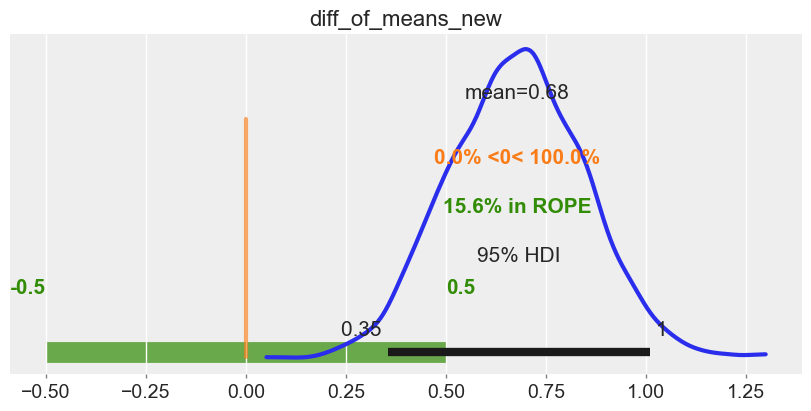

In [24]:
az.plot_posterior(trace_sensitivity,  var_names="diff_of_means_new", ref_val=0, rope=[-0.5,0.5], hdi_prob=0.95)

Given these results:

Evidence Points Towards Hypothesis: With 85% of the posterior distribution outside the ROPE, there's reasonably strong evidence suggesting a practically significant difference between the goals scored at home vs. away.

However, Not Completely Conclusive: The 15% in the ROPE means there's still some uncertainty.

# Preprocessing for hypothesis 2

In [25]:
# Define a dictionary to map German day abbreviations to day names
german_day_names = {
    'Mo': 'Monday',
    'Di': 'Tuesday',
    'Mi': 'Wednesday',
    'Do': 'Thursday',
    'Fr': 'Friday',
    'Sa': 'Saturday',
    'So': 'Sunday'
}

# Map German day abbreviations to day names in a new column
flattened_df['day_of_the_week'] = flattened_df['day_of_the_week'].map(german_day_names)

In [26]:
flattened_df

,Team,Goals,days_of_rest,day_of_the_week,team_code
0,EHC Biel-Bienne,7.0,3.0,Saturday,0
1,EHC Biel-Bienne,1.0,2.0,Friday,0
2,EHC Biel-Bienne,0.0,0.0,Tuesday,0
3,EHC Biel-Bienne,1.0,5.0,Friday,0
4,EHC Biel-Bienne,4.0,3.0,Saturday,0
...,...,...,...,...,...
9795,HC Davos,0.0,0.0,Saturday,7
9796,HC Ambri-Piotta,2.0,1.0,Sunday,6
9797,Fribourg-Gottéron,0.0,0.0,Thursday,3
9798,EHC Kloten,0.0,0.0,Saturday,1


# Hypothesis test 2
We want to see if days of the week affect team efficiency

# Research Question

We want to test the following hypothesis:
- Do games played on different days of the week have different average scores?

We assume that the distribution of the goals scored follows a poisson distribution


# Background information to set the prior
From a research we found the mean goals per game is 5.51 (https://www.sport12x.com/en/mathematics/ice-hockey). Given this we can divide the score between the two teams, resulting in a mean of 2.75 goals per team in one game.

We assume goals scored follow Poisson distribution, then the variance is equal to the mean. This means the standard deviation of goals per team is $SD = \sqrt{mean} = \sqrt{\frac{5.51}{2}} \approx 1.66$

We know that:
$$
\frac{\alpha}{\beta} = \mu
$$
$$
\frac{\alpha}{\beta^2} = \sigma^2
$$

therefore we can calculate alpha and beta as:
$$
\alpha = \frac{\mu^2}{\sigma^2}
$$
$$
\beta = \frac{\mu}{\sigma^2}
$$

In [27]:
mu = 2.75
sigma = 1.37

alpha = mu**2 / sigma**2
beta = mu / sigma**2
alpha, beta

(4.029250359635569, 1.4651819489583886)

# Prior for $\mu_{\text{Monday}}$, $\mu_{\text{Tuesday}}$, $\mu_{\text{Wednesday}}$, $\mu_{\text{Thursday}}$, $\mu_{\text{Friday}}$, $\mu_{\text{Saturday}}$, $\mu_{\text{Sunday}}$

* For each day of the week, we set the prior distribution for the average score as follows:

$$
\mu_{\text{Monday}}   \sim  Gam(4.03,1.47)
$$
$$
\mu_{\text{Tuesday}}   \sim  Gam(4.03,1.47)
$$
$$
\mu_{\text{Wednesday}}   \sim  Gam(4.03,1.47)
$$
$$
\mu_{\text{Thursday}}   \sim  Gam(4.03,1.47)
$$
$$
\mu_{\text{Friday}}   \sim  Gam(4.03,1.47)
$$
$$
\mu_{\text{Saturday}}   \sim  Gam(4.03,1.47)
$$
$$
\mu_{\text{Sunday}}   \sim  Gam(4.03,1.47)
$$

* We assign the same prior distribution to each day of the week to avoid favoring any particular day over another. This ensures that our analysis is unbiased toward any specific day's performance.


# The Probabilistic Model


* We formulate a prior distribution for the average score of home teams as follows:

$$
\mu_{\text{Monday}} \sim Gam(4.03,1.47)
$$
$$
\vec{y}_{\text{Monday}} \sim Po(\mu_{\text{Monday}})
$$
$$
\mu_{\text{Tuesday}} \sim Gam(4.03,1.47)
$$
$$
\vec{y}_{\text{Tuesday}} \sim Po(\mu_{\text{Tuesday}})
$$
$$
\mu_{\text{Wednesday}} \sim Gam(4.03,1.47)
$$
$$
\vec{y}_{\text{Wednesday}} \sim Po(\mu_{\text{Wednesday}})
$$
$$
\mu_{\text{Thursday}} \sim Gam(4.03,1.47)
$$
$$
\vec{y}_{\text{Thursday}} \sim Po(\mu_{\text{Thursday}})
$$
$$
\mu_{\text{Friday}} \sim Gam(4.03,1.47)
$$
$$
\vec{y}_{\text{Friday}} \sim Po(\mu_{\text{Friday}})
$$
$$
\mu_{\text{Saturday}} \sim Gam(4.03,1.47)
$$
$$
\vec{y}_{\text{Saturday}} \sim Po(\mu_{\text{Saturday}})
$$
$$
\mu_{\text{Sunday}} \sim Gam(4.03,1.47)
$$
$$
\vec{y}_{\text{Sunday}} \sim Po(\mu_{\text{Sunday}})
$$

* We model the observed scores for each day of the week using the Poisson distribution with the parameter of the respective average score.

# Comparing the two means

In [28]:
# Extract scores for each day of the week
monday_scores = flattened_df[flattened_df['day_of_the_week'] == 'Monday']['Goals']
tuesday_scores = flattened_df[flattened_df['day_of_the_week'] == 'Tuesday']['Goals']
wednesday_scores = flattened_df[flattened_df['day_of_the_week'] == 'Wednesday']['Goals']
thursday_scores = flattened_df[flattened_df['day_of_the_week'] == 'Thursday']['Goals']
friday_scores = flattened_df[flattened_df['day_of_the_week'] == 'Friday']['Goals']
saturday_scores = flattened_df[flattened_df['day_of_the_week'] == 'Saturday']['Goals']
sunday_scores = flattened_df[flattened_df['day_of_the_week'] == 'Sunday']['Goals']

In [29]:
import pymc3 as pm

with pm.Model() as model_weekdays:
    # Prior
    mu_Monday = pm.Gamma('mu_Monday', alpha, beta)
    mu_Tuesday = pm.Gamma('mu_Tuesday', alpha, beta)
    mu_Wednesday = pm.Gamma('mu_Wednesday', alpha, beta)
    mu_Thursday = pm.Gamma('mu_Thursday', alpha, beta)
    mu_Friday = pm.Gamma('mu_Friday', alpha, beta)
    mu_Saturday = pm.Gamma('mu_Saturday', alpha, beta)
    mu_Sunday = pm.Gamma('mu_Sunday', alpha, beta)

    # Likelihood of scores for each day of the week
    y_Monday = pm.Poisson('y_Monday', mu=mu_Monday, observed=monday_scores)
    y_Tuesday = pm.Poisson('y_Tuesday', mu=mu_Tuesday, observed=tuesday_scores)
    y_Wednesday = pm.Poisson('y_Wednesday', mu=mu_Wednesday, observed=wednesday_scores)
    y_Thursday = pm.Poisson('y_Thursday', mu=mu_Thursday, observed=thursday_scores)
    y_Friday = pm.Poisson('y_Friday', mu=mu_Friday, observed=friday_scores)
    y_Saturday = pm.Poisson('y_Saturday', mu=mu_Saturday, observed=saturday_scores)
    y_Sunday = pm.Poisson('y_Sunday', mu=mu_Sunday, observed=sunday_scores)


    avg_weekday = (mu_Monday + mu_Tuesday + mu_Wednesday + mu_Thursday) / 4
    avg_weekend = (mu_Friday + mu_Saturday + mu_Sunday) / 3

    diff_of_means = pm.Deterministic('diff_weekday_weekend', avg_weekday - avg_weekend)

In [30]:
# Run the sampling
with model_weekdays:
    trace = pm.sample(1000, tune=1000)

/var/folders/n3/51xp5_rs54v10cnshxhwyt480000gn/T/ipykernel_50899/2878600916.py:3: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(1000, tune=1000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_Sunday, mu_Saturday, mu_Friday, mu_Thursday, mu_Wednesday, mu_Tuesday, mu_Monday]
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.


Got error No model on context stack. trying to find log_likelihood in translation.
/Users/christian/miniforge3/envs/bda/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<AxesSubplot: title={'center': 'mu_Monday'}>,
        <AxesSubplot: title={'center': 'mu_Monday'}>],
       [<AxesSubplot: title={'center': 'mu_Tuesday'}>,
        <AxesSubplot: title={'center': 'mu_Tuesday'}>],
       [<AxesSubplot: title={'center': 'mu_Wednesday'}>,
        <AxesSubplot: title={'center': 'mu_Wednesday'}>],
       [<AxesSubplot: title={'center': 'mu_Thursday'}>,
        <AxesSubplot: title={'center': 'mu_Thursday'}>],
       [<AxesSubplot: title={'center': 'mu_Friday'}>,
        <AxesSubplot: title={'center': 'mu_Friday'}>],
       [<AxesSubplot: title={'center': 'mu_Saturday'}>,
        <AxesSubplot: title={'center': 'mu_Saturday'}>],
       [<AxesSubplot: title={'center': 'mu_Sunday'}>,
        <AxesSubplot: title={'center': 'mu_Sunday'}>],
       [<AxesSubplot: title={'center': 'diff_weekday_weekend'}>,
        <AxesSubplot: title={'center': 'diff_weekday_weekend'}>]],
      dtype=object)

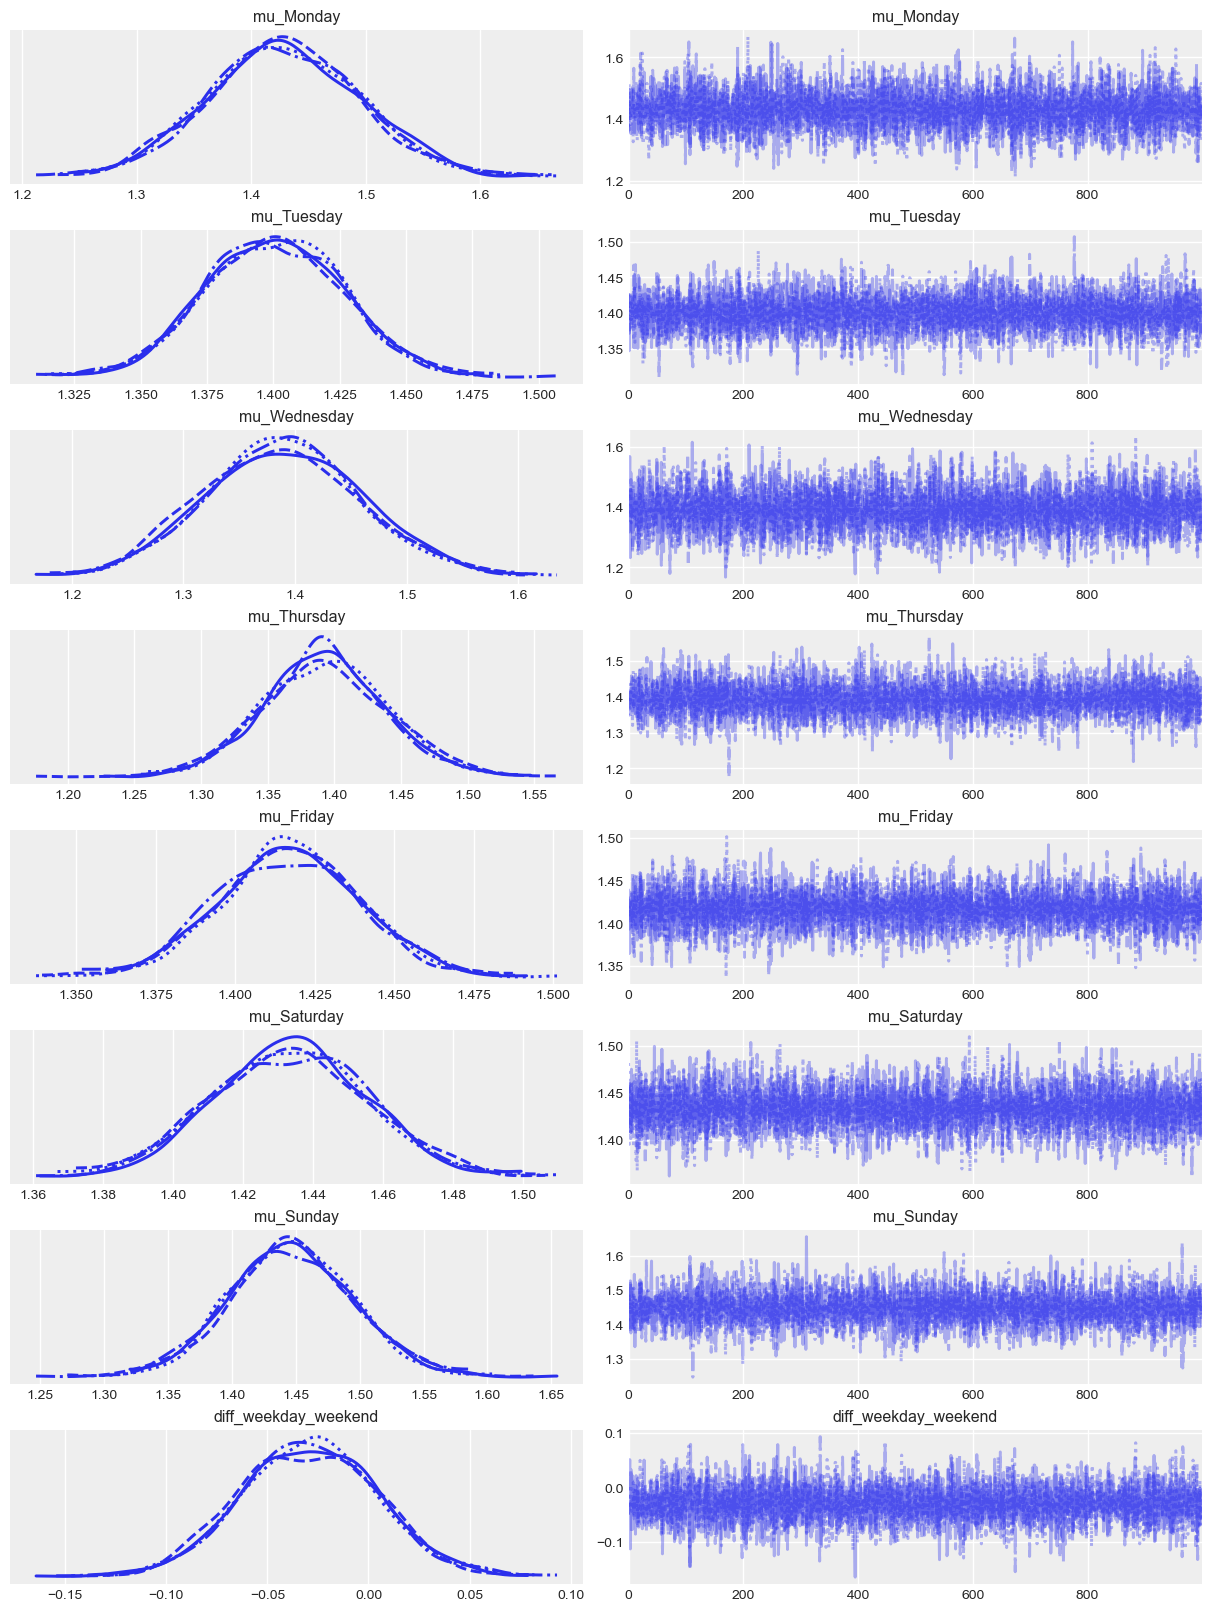

In [31]:
az.plot_trace(trace)

In [32]:
az.summary(trace, hdi_prob=0.95)

Got error No model on context stack. trying to find log_likelihood in translation.
/Users/christian/miniforge3/envs/bda/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_Monday,1.429,0.066,1.300,1.553,0.001,0.001,6465.0,2669.0,1.0
mu_Tuesday,1.400,0.026,1.351,1.451,0.000,0.000,6177.0,3116.0,1.0
mu_Wednesday,1.390,0.070,1.249,1.523,0.001,0.001,6799.0,3205.0,1.0
mu_Thursday,1.393,0.046,1.304,1.485,0.001,0.000,7943.0,3293.0,1.0
mu_Friday,1.417,0.022,1.374,1.460,0.000,0.000,8287.0,3038.0,1.0
mu_Saturday,1.433,0.022,1.389,1.475,0.000,0.000,8314.0,3103.0,1.0
mu_Sunday,1.447,0.048,1.352,1.542,0.001,0.000,6622.0,3160.0,1.0
diff_weekday_weekend,-0.029,0.034,-0.094,0.039,0.000,0.000,6776.0,2897.0,1.0


Got error No model on context stack. trying to find log_likelihood in translation.
/Users/christian/miniforge3/envs/bda/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


<AxesSubplot: title={'center': 'diff_weekday_weekend'}>

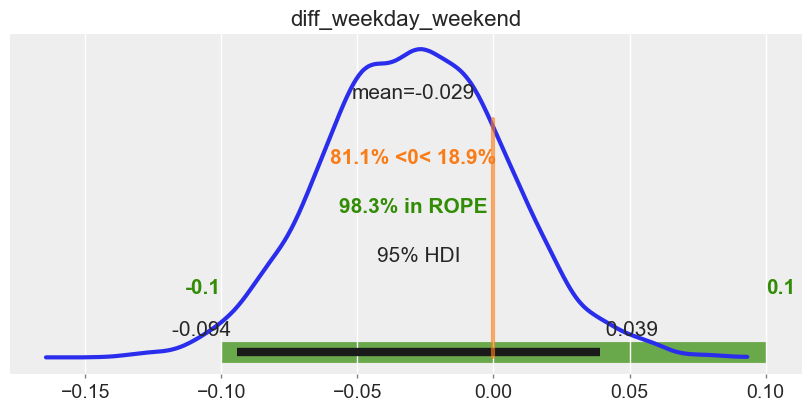

In [33]:
az.plot_posterior(trace,  var_names="diff_weekday_weekend", ref_val=0, hdi_prob=0.95, rope=[-0.1,0.1])

The mean difference between weekdays and weekends (diff_weekday_weekend) is -0.029. A negative value suggests that, on average, weekends might have slightly higher scores than weekdays, but the effect size is small. Moreover, the 95% HDI for the mean difference ranges from -0.094 to 0.039. Since this interval includes 0, this indicates that the difference is not statistically significant at the 95% confidence level.

We set the ROPE test to a small range, since in our opinion there should not be a real difference in performance between weekdays and weekends.
The 95% HDI falls almost completely inside the ROPE, suggesting that the difference of means is not statistically significant nor practically significant.

In [34]:
samples = az.extract(trace)
diff_samples = samples.diff_weekday_weekend.values
p_significant_positive =  ((diff_samples > 0.5).sum()) / len(diff_samples)
p_significant_negative = ((diff_samples < -0.5).sum()) / len(diff_samples)
p_practically_eq = 1 -  p_significant_negative  -  p_significant_positive

print("p_significant_positive: ", "%.3f" % p_significant_positive)
print("p_practically_eq: ", "%.3f" % p_practically_eq)
print("p_significant_negative: ", "%.3f" % p_significant_negative)

Got error No model on context stack. trying to find log_likelihood in translation.


p_significant_positive:  0.000
p_practically_eq:  1.000
p_significant_negative:  0.000


# Posterior predictive checks

/Users/christian/miniforge3/envs/bda/lib/python3.8/site-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


array([<AxesSubplot: xlabel='y_1 / y_1'>,
       <AxesSubplot: xlabel='y_2 / y_2'>], dtype=object)

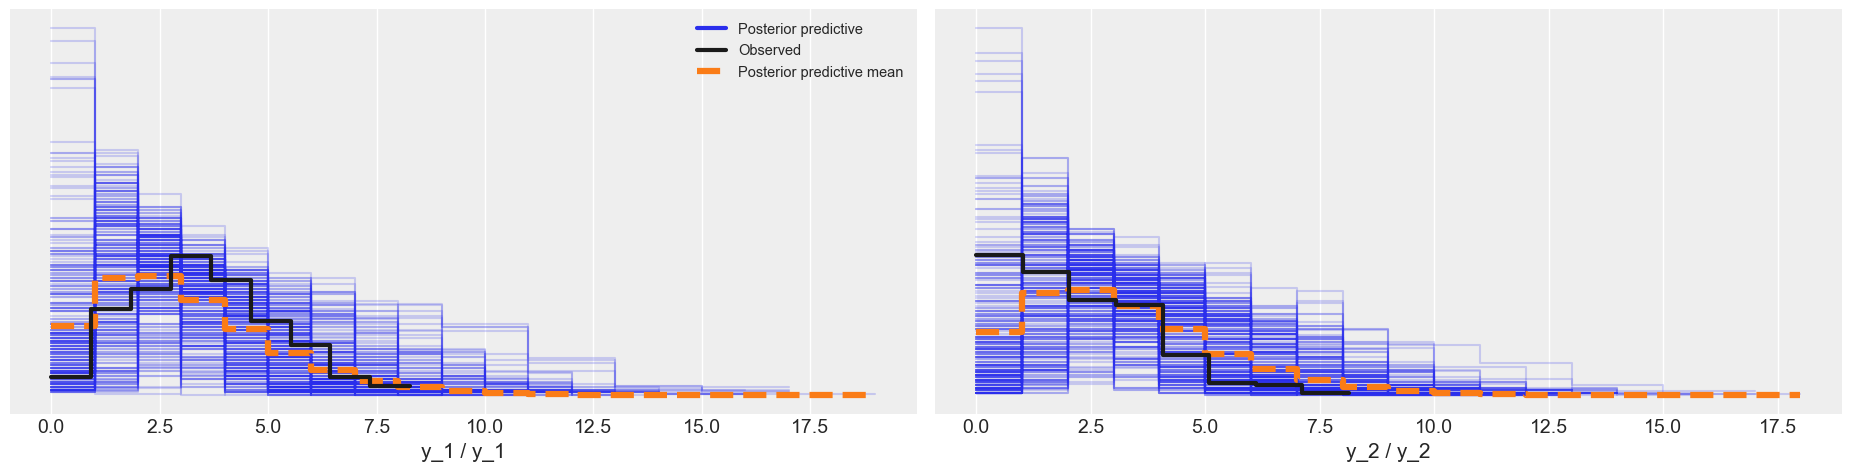

In [35]:
# Quiz yourself: write a pseudo code explaining what the code below does.
with model:
     ppc = pm.sample_posterior_predictive(trace, samples=300)
    
# The density is too low in the bulk of the distribution, for both groups. 
az.plot_ppc(az.from_pymc3(posterior_predictive=ppc, model=model))

## Prior sensitivity

In [36]:
mu_weekdays = 2.75 
# Double the sigma to have a more diffuse prior
sigma_weekdays = sigma * 2

alpha_weekdays = mu_weekdays**2 / sigma_weekdays**2
beta_weekdays = mu_weekdays / sigma_weekdays**2


In [37]:
with pm.Model() as model_weekdays_sensitivity:
    # Prior
    mu_Monday_new = pm.Gamma('mu_Monday_new', alpha_weekdays, beta_weekdays)
    mu_Tuesday_new = pm.Gamma('mu_Tuesday_new', alpha_weekdays, beta_weekdays)
    mu_Wednesday_new = pm.Gamma('mu_Wednesday_new', alpha_weekdays, beta_weekdays)
    mu_Thursday_new = pm.Gamma('mu_Thursday_new', alpha_weekdays, beta_weekdays)
    mu_Friday_new = pm.Gamma('mu_Friday_new', alpha_weekdays, beta_weekdays)
    mu_Saturday_new = pm.Gamma('mu_Saturday_new', alpha_weekdays, beta_weekdays)
    mu_Sunday_new = pm.Gamma('mu_Sunday_new', alpha_weekdays, beta_weekdays)

    # Likelihood of each day
    y_Monday = pm.Poisson('y_Monday', mu=mu_Monday_new, observed=monday_scores)
    y_Tuesday = pm.Poisson('y_Tuesday', mu=mu_Tuesday_new, observed=tuesday_scores)
    y_Wednesday = pm.Poisson('y_Wednesday', mu=mu_Wednesday_new, observed=wednesday_scores)
    y_Thursday = pm.Poisson('y_Thursday', mu=mu_Thursday_new, observed=thursday_scores)
    y_Friday = pm.Poisson('y_Friday', mu=mu_Friday_new, observed=friday_scores)
    y_Saturday = pm.Poisson('y_Saturday', mu=mu_Saturday_new, observed=saturday_scores)
    y_Sunday = pm.Poisson('y_Sunday', mu=mu_Sunday_new, observed=sunday_scores)
    
    avg_weekday_new = (mu_Monday_new + mu_Tuesday_new + mu_Wednesday_new + mu_Thursday_new) / 4
    avg_weekend_new = (mu_Friday_new + mu_Saturday_new + mu_Sunday_new) / 3

    diff_of_means_new = pm.Deterministic('diff_weekday_weekend_new', avg_weekday_new - avg_weekend_new)


In [38]:
with model_weekdays_sensitivity:
    trace_weekdays_sensitivity = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_Sunday_new, mu_Saturday_new, mu_Friday_new, mu_Thursday_new, mu_Wednesday_new, mu_Tuesday_new, mu_Monday_new]
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.


In [39]:
az.summary(trace_weekdays_sensitivity, hdi_prob=0.95)


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_Monday_new,1.427,0.067,1.301,1.562,0.001,0.001,7308.0,3238.0,1.0
mu_Tuesday_new,1.399,0.025,1.352,1.451,0.000,0.000,6571.0,3067.0,1.0
mu_Wednesday_new,1.387,0.069,1.252,1.522,0.001,0.001,6429.0,3116.0,1.0
mu_Thursday_new,1.391,0.048,1.300,1.482,0.001,0.000,6974.0,3384.0,1.0
mu_Friday_new,1.417,0.023,1.373,1.463,0.000,0.000,6643.0,3206.0,1.0
mu_Saturday_new,1.433,0.022,1.389,1.474,0.000,0.000,7006.0,3161.0,1.0
mu_Sunday_new,1.445,0.048,1.355,1.540,0.001,0.000,6418.0,3305.0,1.0
diff_weekday_weekend_new,-0.030,0.033,-0.099,0.034,0.000,0.000,6662.0,3408.0,1.0


<AxesSubplot: title={'center': 'diff_weekday_weekend_new'}>

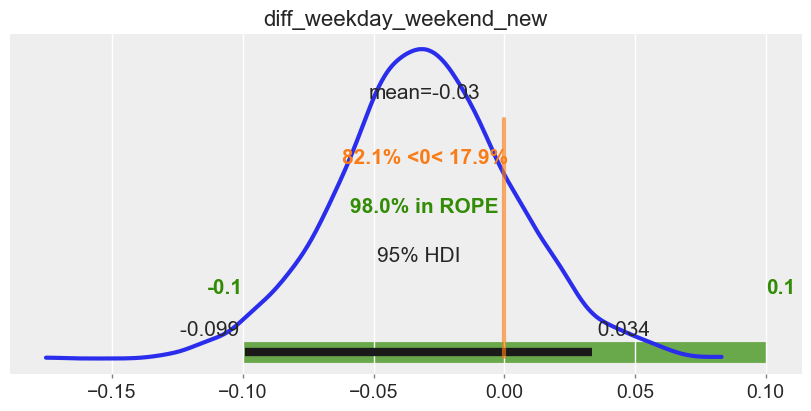

In [40]:
az.plot_posterior(trace_weekdays_sensitivity,  var_names="diff_weekday_weekend_new", ref_val=0, hdi_prob=0.95, rope=[-0.1,0.1])

Due to the narrow ROPE interval, the fact that the distribution is slightly shifted to the left can suggest that in fact, during the weekend (considered from Friday to Sunday), the goals scored are higher.

Similarly to the first model, the 95% HDI almost completely falls in the ROPE region, which makes this difference both statistically and practically not relevant, meaning that the days of the week are not contributing in a higher or lower number of goals scored.